In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [43]:
def extractAndResizeVideoFrames(cap):
  framesCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  frames = np.empty((frameHeight//2, frameWidth//2, framesCount))

  for cnt in range(framesCount):
    _, frame = cap.read()

    grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frames[:,:,cnt] = cv2.resize(grayFrame, None, fx=0.5, fy=0.5)

  return frames.astype(np.uint8)



def trackFeatures(I, detector, maxCorners, qualityLevel, minDistance):
  if detector=="harris":
    useHarrisDetector = True
  else: 
    useHarrisDetector=False

  features = cv2.goodFeaturesToTrack(I, maxCorners, qualityLevel, minDistance, mask=None, blockSize=7, useHarrisDetector=useHarrisDetector)

  return features


def showInterestPoints(image, corners):
  img = image.copy()

  plt.imshow(img, cmap='gray')
  for i in corners:
      x,y = i.ravel()
      circle = plt.Circle((x,y), color='r')
      plt.gcf().gca().add_artist(circle)
  plt.show()

In [44]:
cap = cv2.VideoCapture("Team30.mp4")
frames = extractAndResizeVideoFrames(cap)
cap.release()
print(frames.shape)

(360, 640, 2809)


In [5]:
firstFrame = frames[:,:,0]

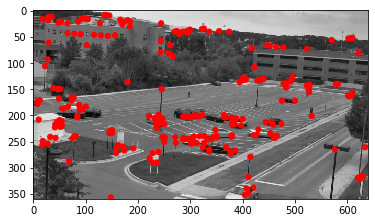

In [70]:
corners = trackFeatures(firstFrame, 'shi-tomasi',maxCorners = 500, qualityLevel = 0.15, minDistance = 3)
showInterestPoints(firstFrame, corners)

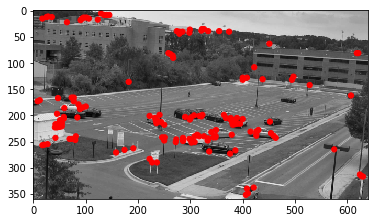

In [71]:
corners_h = trackFeatures(firstFrame,'harris',maxCorners = 1000, qualityLevel = 0.05, minDistance = 3)
showInterestPoints(firstFrame, corners_h)

# Relevant Paper: https://ieeexplore.ieee.org/document/323794

Επιλέξαμε μεγάλο αριθμό στο maxCorners, ώστε ο αλγόριθμος να μας επιστέψει πολλές γωνίες. Το min distance σημαίνει ότι κά

FileNotFoundError: [Errno 2] No such file or directory: 'figures/0000.png'

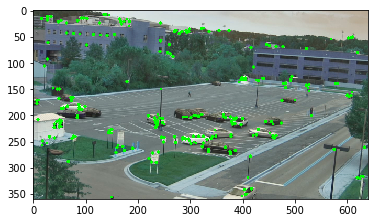

In [66]:
# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

color = (0, 255, 0)

cap = cv2.VideoCapture("Team30.mp4")

ret, first_frame = cap.read()

first_frame = cv2.resize(first_frame, None, fx=0.5, fy=0.5)
# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Finds the strongest corners in the first frame by Shi-Tomasi method - we will track the optical flow for these corners
prev = corners

# Creates an image filled with zero intensities with the same dimensions as the frame - for later drawing purposes
mask = np.zeros_like(first_frame)

count = 0
while(cap.isOpened()):

    ret, frame = cap.read()
    
    frame = cv2.resize(frame, None, fx=0.5, fy=0.5)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Calculates sparse optical flow by Lucas-Kanade method
    next, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev, None, **lk_params)

    # Selects good feature points for previous position
    good_old = prev[status == 1]

    # Selects good feature points for next position
    good_new = next[status == 1]

    # Draws the optical flow tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        # a, b = coordinates of new point
        a, b = new.ravel()
    
        # a, b = coordinates of old point
        c, d = old.ravel()
 
        # Draws line between new and old position with green color and 2 thickness
        mask = cv2.line(mask, (a, b), (c, d), color, 2)

        # Draws filled circle (thickness of -1) at new position with green color and radius of 3
        frame = cv2.circle(frame, (a, b), 3, color, -1)

    # Overlays the optical flow tracks on the original frame
    output = cv2.add(frame, mask)

    # Updates previous frame
    prev_gray = gray.copy()

    # Updates previous good feature points
    prev = good_new.reshape(-1, 1, 2)

    # Opens a new window and displays the output frame
    plt.figure()
    plt.imshow(output)
    plt.savefig('figures/' + str(count).zfill(4) +'.png')
    plt.close()
    count += 1
# The following frees up resources and closes all windows
cap.release()
